# Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, classification_report, accuracy_score, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import plotly.express as px

# Full until 2022

In [2]:
qualified_US_2024 = pd.read_csv('US_2024_qualifed_athlete.csv')
qualified_US_2024['name'] = qualified_US_2024['First_Name'] + ' ' + qualified_US_2024['Last_Name']
qualified_US_2024.drop(columns=['Current Student-Athlete','School_Name','First_Name','Last_Name','Sport_Level'], inplace=True)
cols = qualified_US_2024.columns.tolist()
cols = ['name'] + [col for col in cols if col != 'name']
qualified_US_2024 = qualified_US_2024[cols]
qualified_US_2024.head()

,name,Team_USA_Sport,Gender,Collegiate_Sport
0,Casey Kaufhold,Archery,F,Archery
1,Asher Hong,Artistic Gymnastics,M,Gymnastics
2,Brody Malone,Artistic Gymnastics,M,Gymnastics
3,Frederick Richard,Artistic Gymnastics,M,Gymnastics
4,Jade Carey,Artistic Gymnastics,F,Gymnastics


In [3]:
athlete_bio_full = pd.read_csv("Olympics_1986 to 2022/Olympic_Athlete_Bio.csv", index_col='athlete_id')

athlete_event_results_full = pd.read_csv("Olympics_1986 to 2022/Olympic_Athlete_Event_Results.csv")

games_medal_full = pd.read_csv("Olympics_1986 to 2022/Olympic_Games_Medal_Tally.csv")

overall_results_full = pd.read_csv("Olympics_1986 to 2022/Olympic_Results.csv", index_col='result_id')

countries_full = pd.read_csv("Olympics_1986 to 2022/Olympics_Country.csv", index_col='noc')
countries_full = countries_full[countries_full['country']!='ROC'].copy()
countries_full = countries_full[~countries_full['country'].str.contains('East Germany|West Germany')].copy()

games_full = pd.read_csv("Olympics_1986 to 2022/Olympics_Games.csv", index_col='edition')

In [4]:
# Extract only summer games from 1992
games_summer = games_full.loc[games_full.index.str.contains('Summer')].copy()
games_summer = games_summer[~(games_summer['year'] < 1992)].copy()

athlete_event_results_summer = athlete_event_results_full.loc[athlete_event_results_full['edition'].str.contains('Summer')].copy()
athlete_event_results_summer['year'] = athlete_event_results_summer['edition'].str.extract(r'(\d+)').astype('float64').astype('Int64')
athlete_event_results_summer = athlete_event_results_summer[~(athlete_event_results_summer['year'] < 1992)].copy()
athlete_event_results_summer['medal'].fillna('No medal', inplace=True)

overall_results_summer = overall_results_full.loc[overall_results_full['edition'].str.contains('Summer')].copy()
overall_results_summer['year'] = overall_results_summer['edition'].str.extract(r'(\d+)').astype('float64').astype('Int64')
overall_results_summer = overall_results_summer[~(overall_results_summer['year'] < 1992)].copy()

games_medal_summer = games_medal_full.loc[games_medal_full['edition'].str.contains('Summer')].copy()
games_medal_summer['year'] = games_medal_summer['edition'].str.extract(r'(\d+)').astype('float64').astype('Int64')
games_medal_summer = games_medal_summer[~(games_medal_summer['year'] < 1992)].copy()
games_medal_summer.loc[(games_medal_summer['country'] == 'ROC'),'country'] = 'Russian Olympic Committee'


# Drop rows having index in [2024, 2028, 2032]
games_summer = games_summer[~games_summer.index.str.contains('2024|2028|2032')].copy()

/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_48905/1921465289.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  athlete_event_results_summer['medal'].fillna('No medal', inplace=True)


In [5]:
# Number of athletes per year
nathlete_per_year = pd.DataFrame(athlete_event_results_summer.groupby(['edition']).athlete_id.nunique().copy())
nathlete_per_year.rename(columns={'athlete_id':'athlete_count'}, inplace=True)
nathlete_per_year.reset_index(inplace=True)

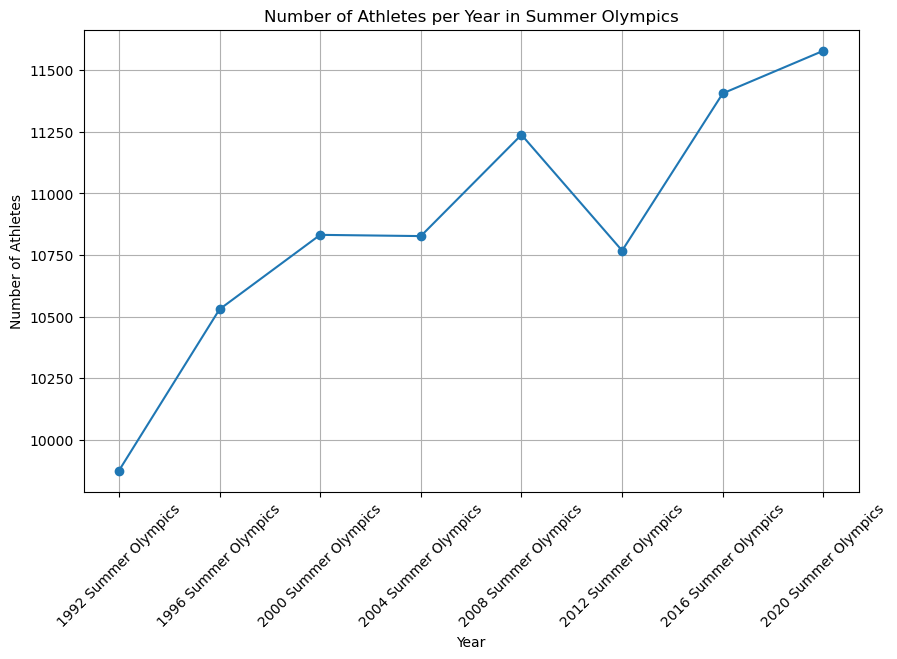

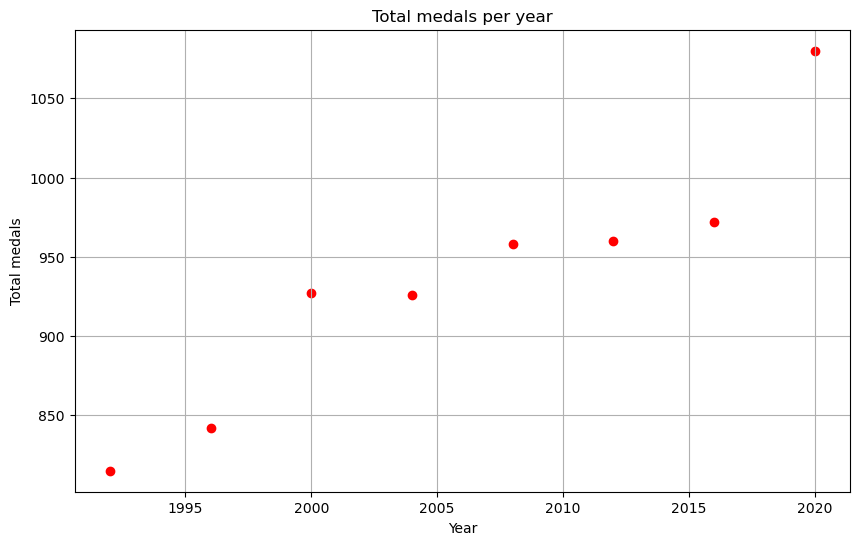

In [6]:
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(nathlete_per_year['edition'], nathlete_per_year['athlete_count'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Athletes')
plt.title('Number of Athletes per Year in Summer Olympics')
plt.grid(True)
plt.xticks(rotation=45)

country_medal = pd.DataFrame(games_medal_summer.groupby('year')['total'].sum()).reset_index()
plt.figure(figsize=(10, 6))
plt.scatter(pd.DataFrame(games_medal_summer.groupby('year')['total'].sum()).reset_index()['year'], pd.DataFrame(games_medal_summer.groupby('year')['total'].sum()).reset_index()['total'], color="red")
plt.xlabel('Year')
plt.ylabel('Total medals')
plt.title('Total medals per year')
plt.grid(True)
plt.show()

# Countries vs. percentage medal

In [7]:
def plot_country_vs_percent(year, percent):
    data = games_medal_summer[(games_medal_summer['year']==year)]
    data = data[['year','percent','country']]
    less_than_2 = data[data['percent'] < percent]
    sum_percent_less_than_2 = less_than_2['percent'].sum()
    new_row = pd.DataFrame([[2004, sum_percent_less_than_2, 'Other']], columns=['year', 'percent', 'country'])
    data = pd.concat([data, new_row], ignore_index=True)
    data = data[data['percent'] >= percent]

    plt.figure(figsize=(10, 7))
    plt.pie(data['percent'], labels=data['country'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Medal Percentage by Country in {year}')
    plt.axis('equal')
    plt.show()

In [8]:
games_medal_summer = pd.merge(country_medal, games_medal_summer, on='year', how='inner')
games_medal_summer.rename(columns={'total_x':'Total per year','total_y':'Total per country'}, inplace=True)
games_medal_summer['percent'] = games_medal_summer['Total per country'] / games_medal_summer['Total per year'] * 100
games_medal_summer['country'] = games_medal_summer['country'].str.strip()

In [9]:
games_medal_summer[games_medal_summer['country_noc'].str.contains('GDR')]

,year,Total per year,edition,edition_id,country,country_noc,gold,silver,bronze,Total per country,percent


In [10]:
print(sorted(list(games_medal_summer['country'].unique())))

['Afghanistan', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Barbados', 'Belarus', 'Belgium', 'Bermuda', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cameroon', 'Canada', 'Chile', 'Chinese Taipei', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Czechoslovakia', "Côte d'Ivoire", "Democratic People's Republic of Korea", 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'Eritrea', 'Estonia', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Great Britain', 'Greece', 'Grenada', 'Guatemala', 'Hong Kong, China', 'Hungary', 'Iceland', 'Independent Olympic Athletes', 'India', 'Indonesia', 'Ireland', 'Islamic Republic of Iran', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kingdom of Saudi Arabia', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Malaysia', 'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Namibia', 'Netherl

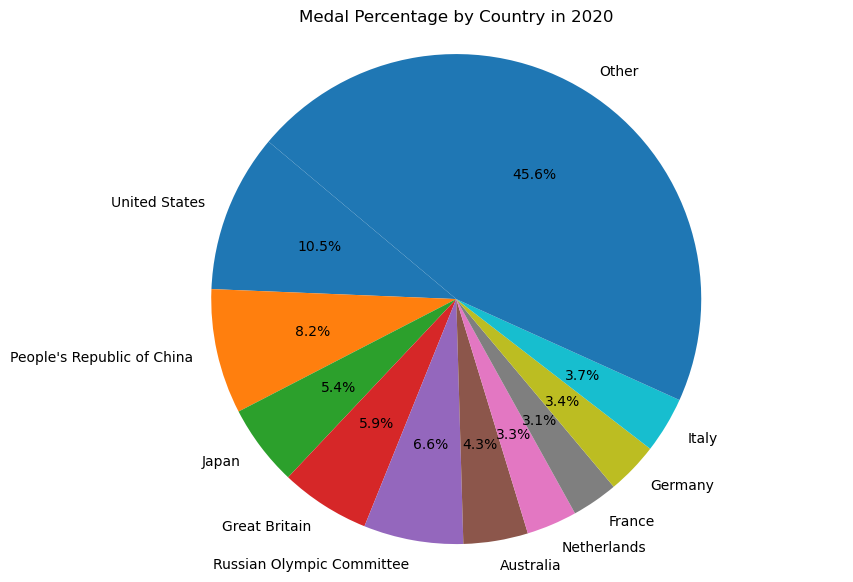

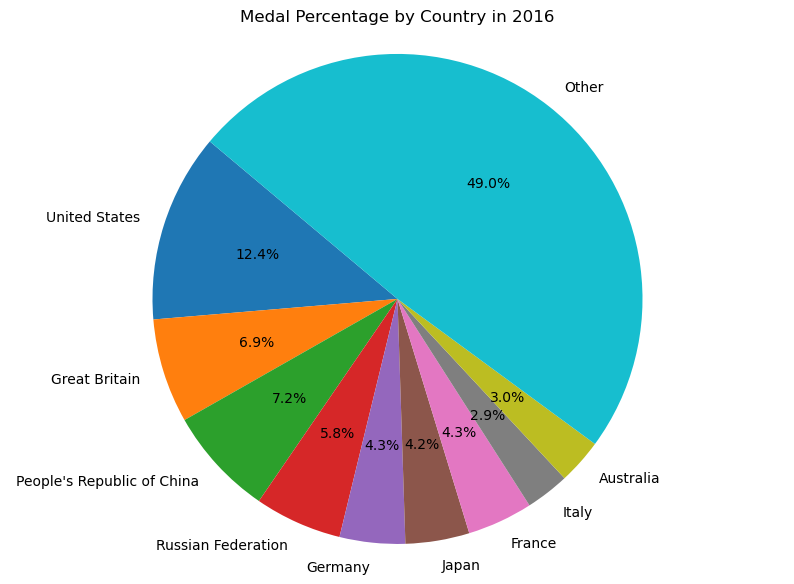

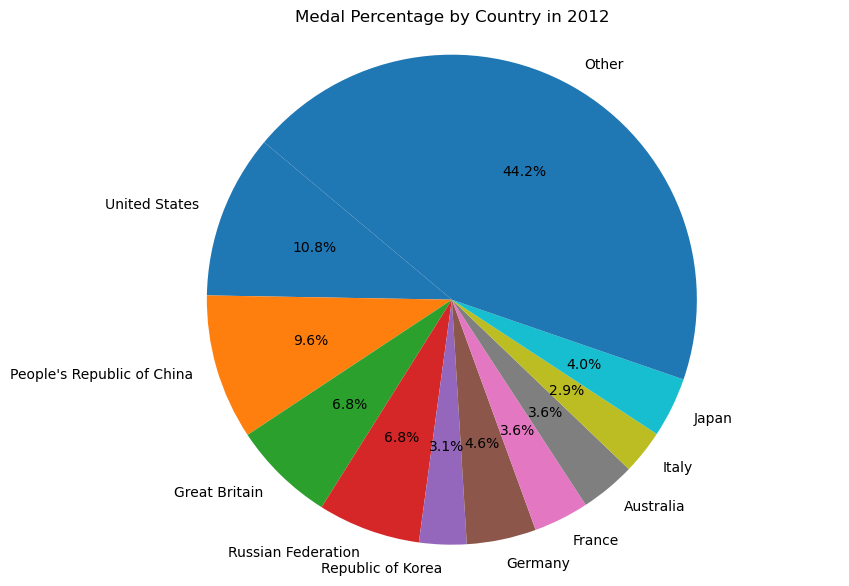

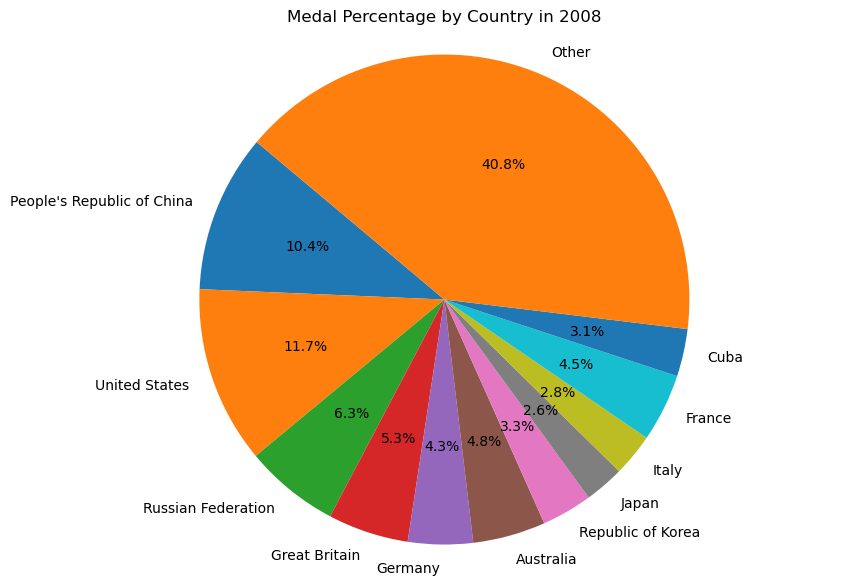

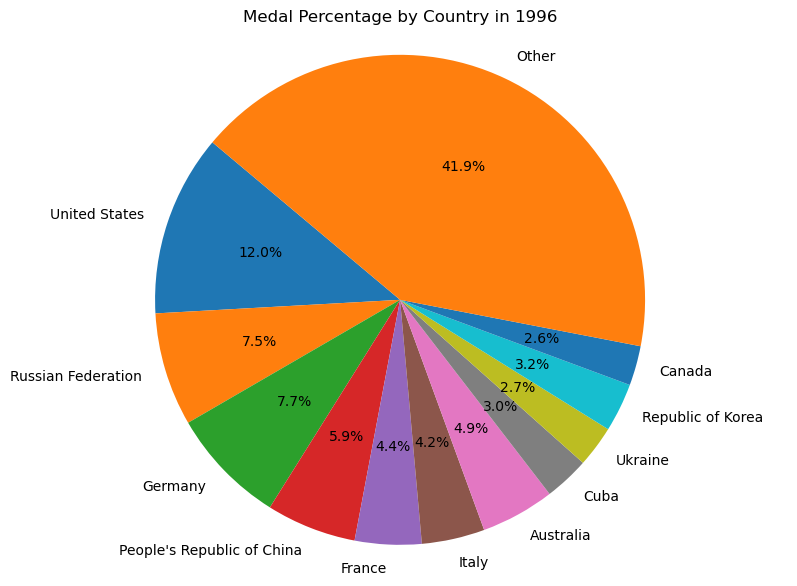

In [11]:
plot_country_vs_percent(2020, 2.5)
plot_country_vs_percent(2016,2.5)
plot_country_vs_percent(2012,2.5)
plot_country_vs_percent(2008,2.5)
plot_country_vs_percent(1996,2.5)

In [12]:
games_summer[games_summer['year'] == 2008]

,edition_id,edition_url,year,city,country_flag_url,country_noc,start_date,end_date,competition_date,isHeld
edition,,,,,,,,,,
2008 Summer Olympics,53,/editions/53,2008,Beijing,https://olympedia-flags.s3.eu-central-1.amazon...,CHN,8 August,24 August,6 – 24 August,NaN


## Features: country, percentage medal per country per year, event, gender, sport

## Visualizations:
- Sport vs. Country (counted based on number of medals)
- % medal per country vs. Year
- Each gender vs. Medals gained (per year)
- 

# Countries vs. # participants

In [13]:
athlete_full_info = pd.merge(athlete_event_results_summer, athlete_bio_full, how='outer', on='athlete_id').reset_index()
athlete_full_info['country_noc_x'] = athlete_full_info['country_noc_y']
athlete_full_info.drop(columns=['country_noc_y'], inplace=True)
athlete_full_info.rename(columns={'country_noc_x':'country_noc'}, inplace=True)
athlete_full_info['edition_id'].fillna(0,inplace=True)
athlete_full_info['result_id'].fillna(0,inplace=True)
athlete_full_info['medal'].fillna('No medal', inplace=True)
athlete_full_info['born'].fillna('0000', inplace=True)


athlete_full_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206440 entries, 0 to 206439
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   index          206440 non-null  int64  
 1   edition        111271 non-null  object 
 2   edition_id     206440 non-null  float64
 3   country_noc    206440 non-null  object 
 4   sport          111271 non-null  object 
 5   event          111271 non-null  object 
 6   result_id      206440 non-null  float64
 7   athlete        111271 non-null  object 
 8   athlete_id     206440 non-null  int64  
 9   pos            111271 non-null  object 
 10  medal          206440 non-null  object 
 11  isTeamSport    111271 non-null  object 
 12  year           111271 non-null  Int64  
 13  name           206440 non-null  object 
 14  sex            206440 non-null  object 
 15  born           206440 non-null  object 
 16  height         152445 non-null  float64
 17  weight         152445 non-nul

/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_48905/1393014818.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  athlete_full_info['edition_id'].fillna(0,inplace=True)
/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_48905/1393014818.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [14]:
country_participants = pd.DataFrame(athlete_full_info.groupby(['year','country_noc']).size()).reset_index()
country_participants = pd.merge(country_participants, countries_full, how='outer', left_on='country_noc', right_on='noc')
country_participants.rename(columns={0: 'total players'}, inplace=True)
country_participants.sort_values(by=['year','total players'], inplace=True)
country_participants.dropna(axis='rows', subset='year', inplace=True)
country_participants.dropna(axis='rows', subset='country', inplace=True)

<Figure size 1000x800 with 0 Axes>

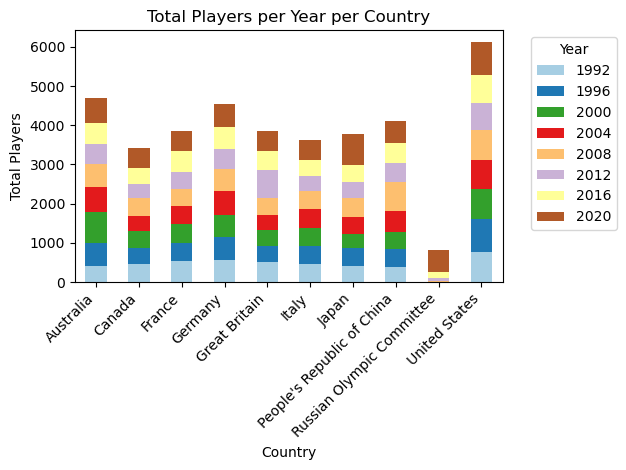

In [15]:
sample = country_participants[country_participants['country'].isin(['United States','Germany','Australia','Japan','Great Britain','Canada','Italy','France','Russian Olympic Committee',"People's Republic of China"])]
pivot_data = sample.pivot_table(index='country', columns='year', values='total players', aggfunc='sum')

# Create a stacked bar plot
plt.figure(figsize=(10, 8))
pivot_data.plot(kind='bar', stacked=True, colormap='Paired')
plt.xlabel('Country')
plt.ylabel('Total Players')
plt.title('Total Players per Year per Country')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Age vs. performance

In [16]:
athlete_full_info.columns

Index(['index', 'edition', 'edition_id', 'country_noc', 'sport', 'event',
       'result_id', 'athlete', 'athlete_id', 'pos', 'medal', 'isTeamSport',
       'year', 'name', 'sex', 'born', 'height', 'weight', 'country',
       'description', 'special_notes'],
      dtype='object')

In [17]:
df = athlete_full_info[['result_id','medal','born','athlete_id','country','country_noc']]
df['born'].fillna('0000',inplace=True)
df['born'] = df['born'].str[-4:]

# idx = df[df['born'].str.contains('\)')].index
df = df.loc[~df['born'].str.contains('\)')]
df = df.loc[~df['born'].str.contains('0000')]
df['born'] = pd.to_numeric(df['born'])
df = df.loc[~(df['born'] < 1992)]

/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_48905/2761305930.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['born'].fillna('0000',inplace=True)
/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_48905/2761305930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['born'].fillna('0000',inplace=True)
/var/folder

In [18]:
df2 = pd.DataFrame(df.groupby(['born','medal']).value_counts())
df2

count
born medal    result_id  athlete_id country                    country_noc       
1992 Bronze   259060.0   116030     People's Republic of China CHN              1
              259982.0   117646     People's Republic of China CHN              1
              259985.0   117662     Romania                    ROU              1
                         117664     Romania                    ROU              1
              259994.0   117646     People's Republic of China CHN              1
...                                                                           ...
2007 No medal 18000391.0 143327     Germany                    GER              1
2008 Bronze   18000391.0 143068     Great Britain              GBR              1
     Silver   18000377.0 141168     Brazil                     BRA              1
              18000391.0 144431     Japan                      JPN              1
2009 No medal 19004030.0 146782     Syrian Arab Republic       SYR              1

[20917 rows x 1 columns]

<Figure size 1000x800 with 0 Axes>

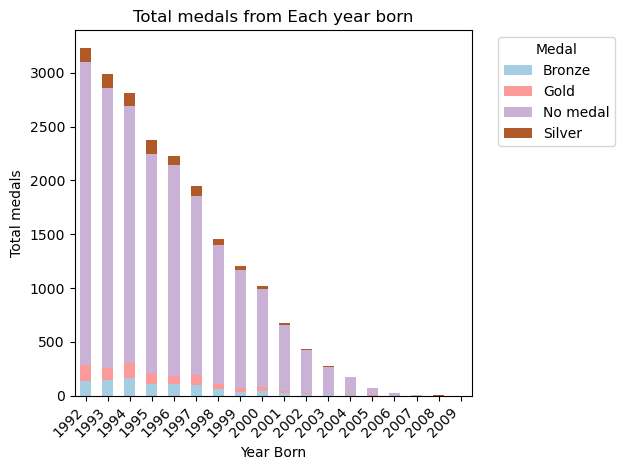

In [19]:
pivot_data2 = df2.pivot_table(index='born', columns='medal', values='count', aggfunc='sum')

# Create a stacked bar plot
plt.figure(figsize=(10, 8))
pivot_data2.plot(kind='bar', stacked=True, colormap='Paired')
plt.xlabel('Year Born')
plt.ylabel('Total medals')
plt.title('Total medals from Each year born')
plt.legend(title='Medal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Being host vs. performance

In [20]:
games_summer['year'] = games_summer.index.str[:4]
games_summer['year'] = pd.to_numeric(games_summer['year'])
games_summer.reset_index(inplace=True)
games_summer.drop(columns=['edition','country_flag_url','competition_date','start_date','end_date','edition_url','isHeld'], axis=1, inplace=True)

In [21]:
games_summer.head()

,edition_id,year,city,country_noc
0,23,1992,Barcelona,ESP
1,24,1996,Atlanta,USA
2,25,2000,Sydney,AUS
3,26,2004,Athina,GRE
4,53,2008,Beijing,CHN


/var/folders/lt/42qswnrj5_3cd5pgfvbrqrk00000gn/T/ipykernel_48905/143431645.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(merged_df['country'])


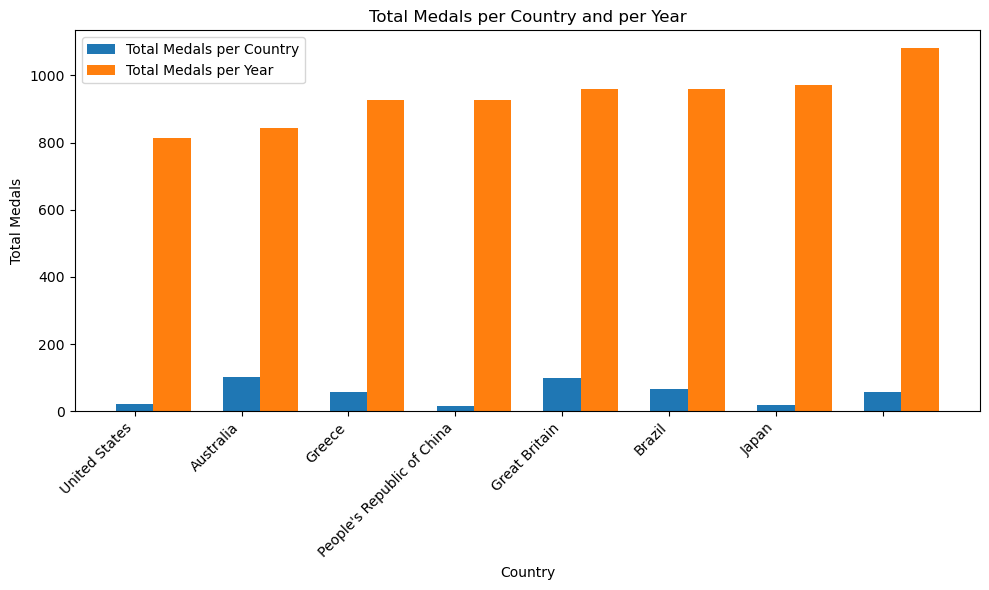

In [22]:
merged_df = pd.merge(games_summer, games_medal_summer, left_on=['year', 'country_noc'], right_on=['year', 'country_noc'], how='left')
merged_df.head(20)

fig, ax = plt.subplots(figsize=(10, 6))

# Number of bars
n = len(merged_df)

# Bar width
bar_width = 0.35

# Positions of bars on x-axis
index = np.arange(n)

# Plotting the bars
bar1 = ax.bar(index, merged_df['Total per country'], bar_width, label='Total Medals per Country')
bar2 = ax.bar(index + bar_width, merged_df['Total per year'], bar_width, label='Total Medals per Year')

# Adding labels, title, and customizing
ax.set_xlabel('Country')
ax.set_ylabel('Total Medals')
ax.set_title('Total Medals per Country and per Year')
ax.set_xticklabels(merged_df['country'])
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()